<a href="https://colab.research.google.com/github/nemoiitkgp/FWI-Codes-PhD/blob/main/BP_2004_Model_(T4_GPU).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip -q install deepwave scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 MB 15.5 MB/s eta 0:00:00


Device: cuda
Starting FINAL HIGH-RES FWI: 1799x637 grid | dx=37.5m | accuracy=8

--- STAGE 1: 2.5 Hz ---
Epoch 10/50: Loss = 10041.414345
Epoch 20/50: Loss = 6955.540619
Epoch 30/50: Loss = 5336.443062
Epoch 40/50: Loss = 4174.632660
Epoch 50/50: Loss = 3731.215225

--- STAGE 2: 4.5 Hz ---
Epoch 10/50: Loss = 2702.799196
Epoch 20/50: Loss = 2136.131487
Epoch 30/50: Loss = 1840.074554
Epoch 40/50: Loss = 1719.641950
Epoch 50/50: Loss = 1628.198854

--- STAGE 3: 6.5 Hz ---


/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 6.5, a minimum non-zero velocity of 1429.000244140625, and a grid cell spacing of 37.5, there are only 5.86.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 6.5, a minimum non-zero velocity of 1450.0, and a grid cell spacing of 37.5, there are only 5.95.
  warnings.warn(


Epoch 10/50: Loss = 1730.239405
Epoch 20/50: Loss = 1262.332981
Epoch 30/50: Loss = 1090.931364
Epoch 40/50: Loss = 1015.075783
Epoch 50/50: Loss = 980.991736


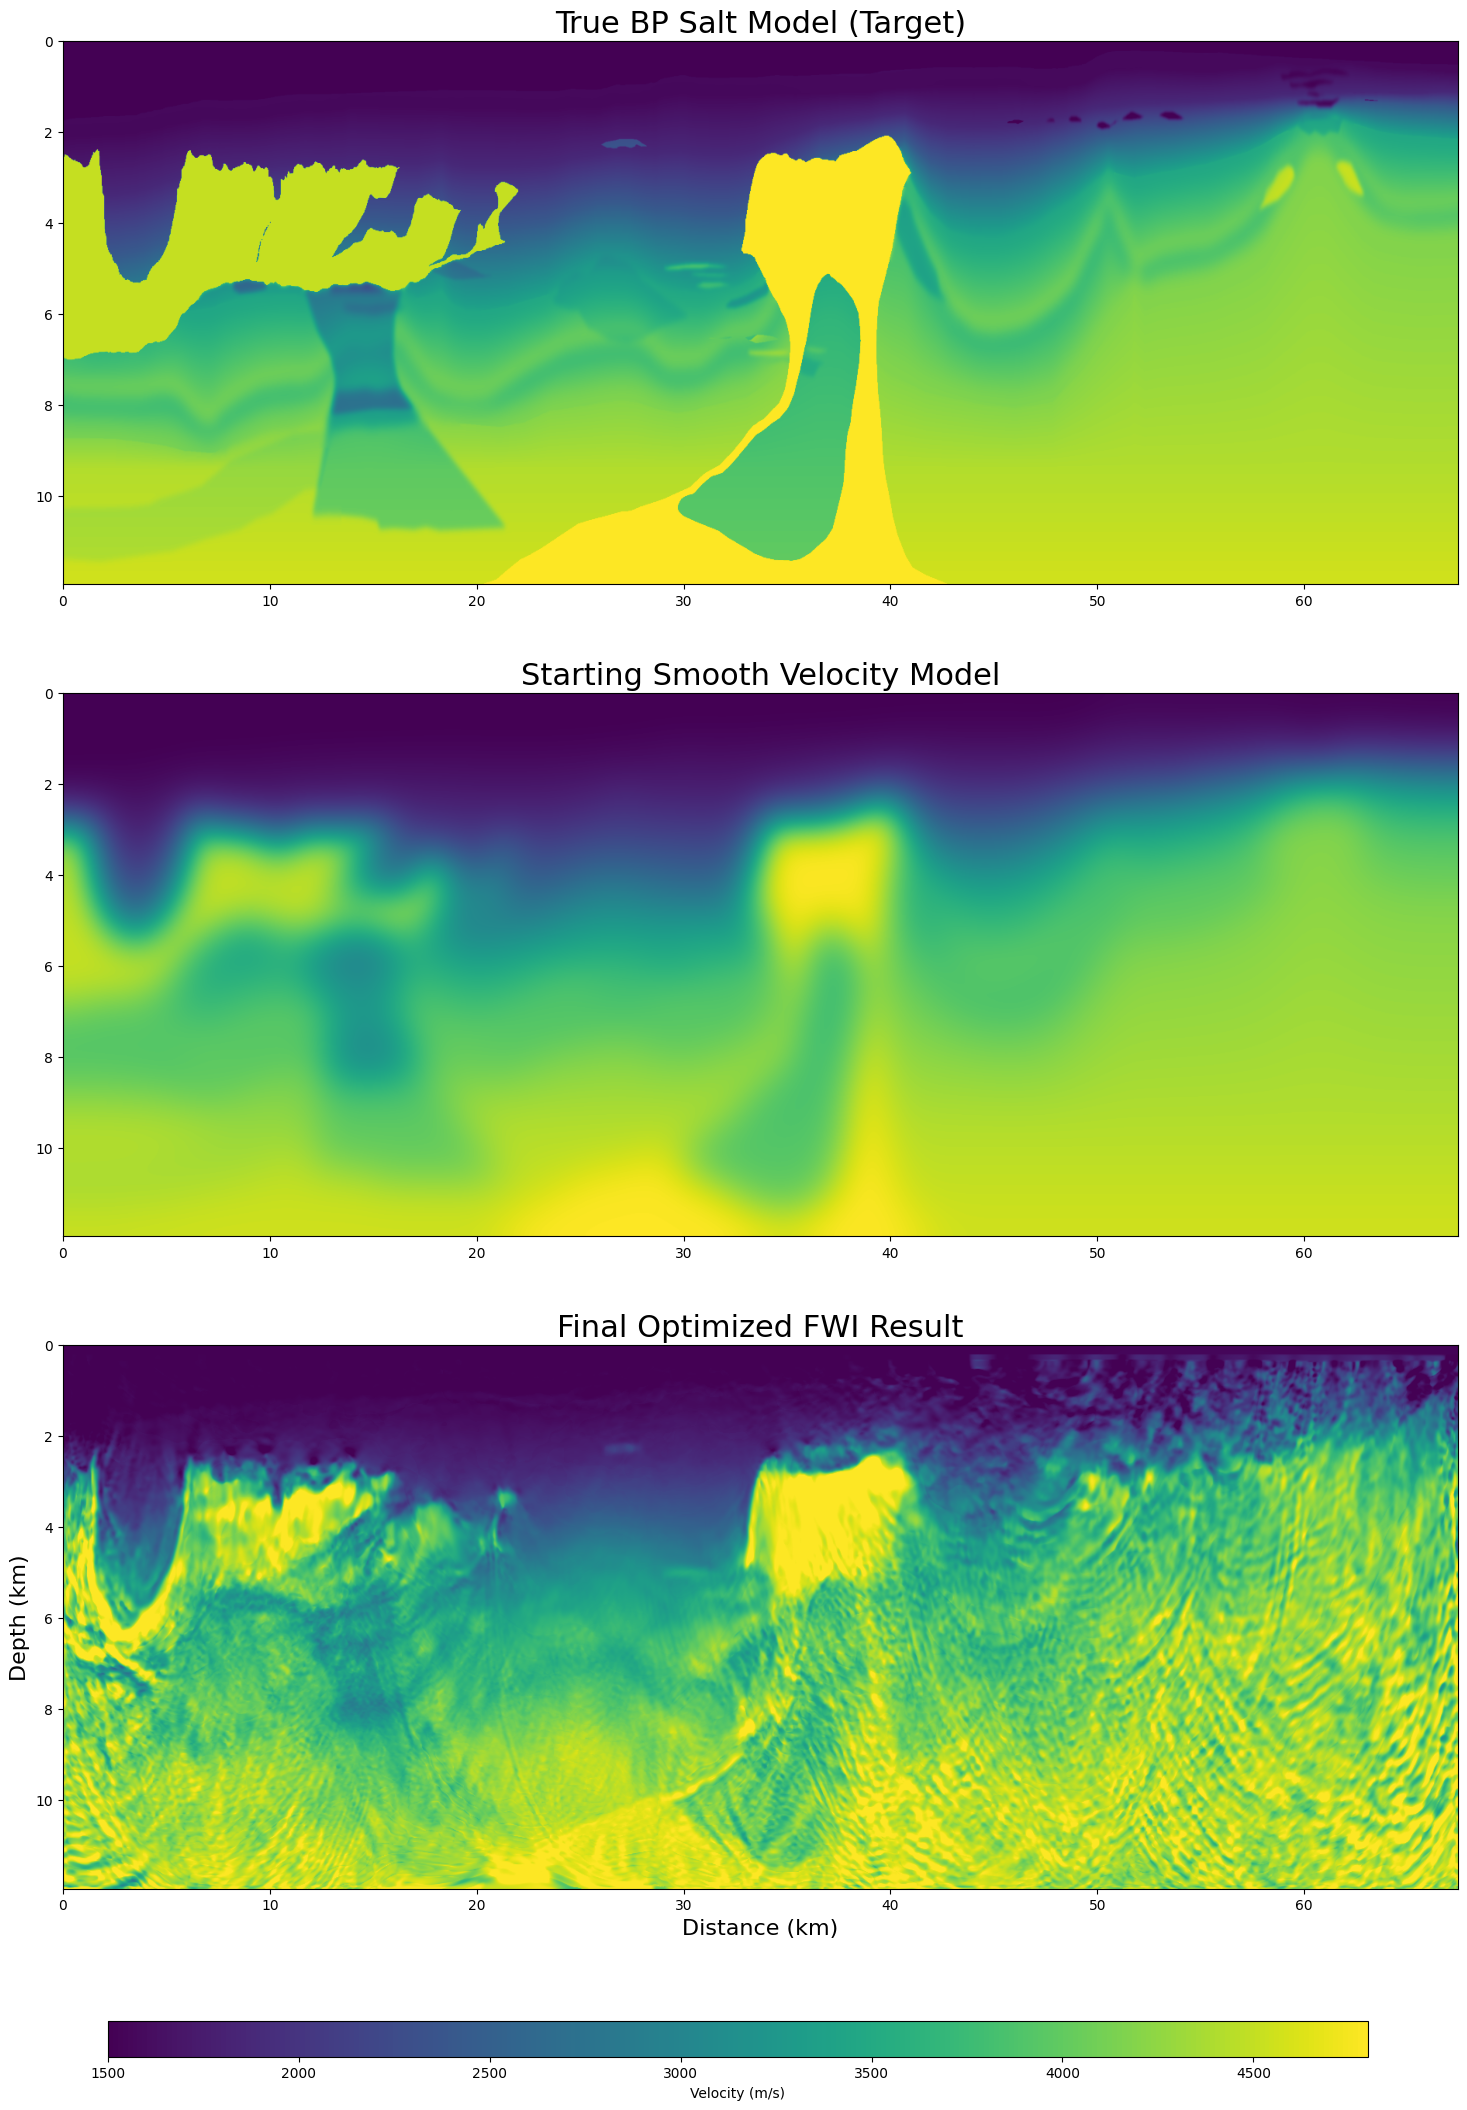

In [6]:
import os
import gc
import numpy as np
import torch
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar

# Memory management
os.environ['PYTORCH_ALLOC_CONF'] = 'expandable_segments:True'

def cleanup():
    torch.cuda.empty_cache()
    gc.collect()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# --- BP SALT MODEL PARAMETERS ---
vp_path = 'BP_salt.bin'
nx0, nz0 = 5395, 1911
dx0, dz0 = 12.5, 6.26

# Load model
vp_cpu = torch.from_file(vp_path, size=nx0 * nz0, dtype=torch.float32).reshape(nx0, nz0)

# PREPROCESSING: Factor 3 provides the resolution needed for high-quality salt imaging
factor = 3
vp_np = vp_cpu.numpy()
vp_reduced = gaussian_filter(vp_np, sigma=0.5)[::factor, ::factor]
nx, nz = vp_reduced.shape

dx, dz = dx0 * factor, dz0 * factor
spacing = (dx, dz)
extent_km = [0, ((nx-1)*dx)/1000, ((nz-1)*dz)/1000, 0]

v_true = torch.from_numpy(vp_reduced).to(device)
# Initial Model: Smooth inverse velocity to preserve low-frequency background
v_init = torch.from_numpy(1.0 / gaussian_filter(1.0 / vp_reduced, sigma=25)).to(device)
v1 = v_init.clone().requires_grad_()

# --- ACQUISITION PARAMETERS ---
n_shots = 35
n_receivers_per_shot = 450 # Increased aperture for deep salt root illumination
nt = 2200 # 8.8 seconds to capture the deepest reflections
dt = 0.004

source_loc = torch.zeros(n_shots, 1, 2, dtype=torch.long, device=device)
source_loc[..., 1] = 3
source_loc[:, 0, 0] = torch.linspace(0, nx - 1, n_shots).round()

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = 3
receiver_loc[:, :, 0] = torch.linspace(0, nx - 1, n_receivers_per_shot).round()

# --- PRE-CONDITIONING TOOLS ---
# 1. Mask for water column (constant 1500 m/s)
water_depth_cells = int(450 / dz)
mask = torch.ones_like(v_init)
mask[:, :water_depth_cells] = 0.0

# 2. Advanced Depth Weighting: Balances shallow and deep illumination
z_coord = torch.linspace(0, 1, nz).to(device)
depth_weight = (1.0 + 35.0 * z_coord**2.5).repeat(nx, 1)

# 3. Time Gain: Boosts weak arrivals from deep sub-salt layers
t = torch.linspace(0, nt*dt, nt).to(device)
t_gain = torch.exp(0.7 * t).view(1, 1, nt)

# --- INVERSION SETUP ---
freqs = [2.5, 4.5, 6.5]
epochs_per_stage = 50
# Adam optimizer with a decaying learning rate across stages
lrs = [20.0, 15.0, 10.0]
all_losses = []

print(f"Starting FINAL HIGH-RES FWI: {nx}x{nz} grid | dx={dx:.1f}m | accuracy=8")

for f_idx, freq in enumerate(freqs):
    print(f"\n--- STAGE {f_idx+1}: {freq} Hz ---")
    cleanup()

    peak_time = 1.5/freq
    source_amp = (deepwave.wavelets.ricker(freq, nt, dt, peak_time)
                  .repeat(n_shots, 1, 1).to(device))

    # Generate reference data
    with torch.no_grad():
        obs_data_list = []
        for i in range(n_shots):
            out = scalar(v_true, spacing, dt, source_amplitudes=source_amp[i:i+1],
                         source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                         accuracy=8, pml_freq=freq, pml_width=[30, 30, 30, 30])
            shot_data = deepwave.common.cosine_taper_end(out[-1], n_taper=60) * t_gain
            obs_data_list.append(shot_data.cpu())
        obs_data = torch.cat(obs_data_list, dim=0)

    # Optimization Stage
    optimizer = torch.optim.Adam([v1], lr=lrs[f_idx])

    for epoch in range(epochs_per_stage):
        optimizer.zero_grad()
        epoch_loss = 0

        for i in range(n_shots):
            # model_gradient_sampling_interval=8 is CRITICAL to fit high-res in 15GB GPU
            out_pred = scalar(v1, spacing, dt, source_amplitudes=source_amp[i:i+1],
                              source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                              accuracy=8, pml_freq=freq, pml_width=[30, 30, 30, 30],
                              model_gradient_sampling_interval=8)

            pred = deepwave.common.cosine_taper_end(out_pred[-1], n_taper=60) * t_gain
            loss = torch.nn.functional.mse_loss(pred, obs_data[i:i+1].to(device)) / n_shots
            loss.backward()
            epoch_loss += loss.item()

        # Advanced Gradient Conditioning
        with torch.no_grad():
            v1.grad *= (mask * depth_weight)

            # 2D Anisotropic Smoothing: Smooth more horizontally to build layers
            # sigma_x (horizontal) > sigma_z (vertical)
            sigma_z = 3.5 / (f_idx + 1.2)
            sigma_x = sigma_z * 2.0
            grad_np = v1.grad.cpu().numpy()
            grad_smoothed = gaussian_filter(grad_np, sigma=(sigma_x, sigma_z))
            v1.grad.copy_(torch.tensor(grad_smoothed).to(device))

        optimizer.step()
        v1.data.clamp_(min=1450.0, max=4850.0)
        all_losses.append(epoch_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs_per_stage}: Loss = {epoch_loss:.6f}")

# --- FINAL VISUALIZATION ---
fig, ax = plt.subplots(3, 1, figsize=(18, 24))
opts = {'cmap': 'viridis', 'aspect': 'auto', 'extent': extent_km, 'vmin': 1500, 'vmax': 4800}

ax[0].imshow(v_true.cpu().T, **opts)
ax[0].set_title("True BP Salt Model (Target)", fontsize=22)

ax[1].imshow(v_init.cpu().T, **opts)
ax[1].set_title("Starting Smooth Velocity Model", fontsize=22)

im = ax[2].imshow(v1.detach().cpu().T, **opts)
ax[2].set_title(f"Final Optimized FWI Result", fontsize=22)
ax[2].set_xlabel("Distance (km)", fontsize=16)
ax[2].set_ylabel("Depth (km)", fontsize=16)

cbar_ax = fig.add_axes([0.15, 0.04, 0.7, 0.015])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label="Velocity (m/s)")
plt.show()

### CPU

In [ ]:
import os
import gc
import numpy as np
import torch
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar

# Memory and performance tuning
os.environ['PYTORCH_ALLOC_CONF'] = 'expandable_segments:True'

def cleanup():
    torch.cuda.empty_cache()
    gc.collect()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# --- BP SALT MODEL PARAMETERS ---
vp_path = 'BP_salt.bin'
nx0, nz0 = 5395, 1911
dx0, dz0 = 12.5, 6.26

# Load original model
vp_cpu = torch.from_file(vp_path, size=nx0 * nz0, dtype=torch.float32).reshape(nx0, nz0)

# PREPROCESSING: Factor 2.5 (dx=31.25m, dz=15.65m)
# High resolution to perfectly support up to 7Hz without any warnings.
factor = 2.5
vp_np = vp_cpu.numpy()
vp_reduced = gaussian_filter(vp_np, sigma=0.5)[::int(factor), ::int(factor)]
nx, nz = vp_reduced.shape

dx, dz = dx0 * factor, dz0 * factor
spacing = (dx, dz)
extent_km = [0, ((nx-1)*dx)/1000, ((nz-1)*dz)/1000, 0]

v_true = torch.from_numpy(vp_reduced).to(device)
# Initial Model: Smooth background trend (crucial for salt FWI)
v_init = torch.from_numpy(1.0 / gaussian_filter(1.0 / vp_reduced, sigma=25)).to(device)
v1 = v_init.clone().requires_grad_()

# --- ACQUISITION PARAMETERS ---
n_shots = 36
n_receivers_per_shot = 500 # Wide aperture to see under the salt
nt = 2400 # 9.6 seconds - Required to record reflections from 12km depth
dt = 0.004

source_loc = torch.zeros(n_shots, 1, 2, dtype=torch.long, device=device)
source_loc[..., 1] = 2
source_loc[:, 0, 0] = torch.linspace(0, nx - 1, n_shots).round()

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = 2
receiver_loc[:, :, 0] = torch.linspace(0, nx - 1, n_receivers_per_shot).round()

# --- PRE-CONDITIONING ---
water_depth_cells = int(450 / dz)
mask = torch.ones_like(v_init)
mask[:, :water_depth_cells] = 0.0

# Exponential Depth Weight: Compensates for massive energy loss through salt
z = torch.linspace(0, 1, nz).to(device)
depth_weight = (1.0 + 40.0 * z**3).repeat(nx, 1)

# Time Gain: Corrects for amplitude decay over 9.6 seconds
t_axis = torch.linspace(0, nt*dt, nt).to(device)
t_gain = torch.exp(0.75 * t_axis).view(1, 1, nt)

# --- INVERSION SETUP ---
freqs = [3.0, 5.0, 7.0]
epochs_per_stage = 50
lrs = [22.0, 15.0, 8.0] # Decreasing learning rate for fine-tuning
all_losses = []

print(f"Starting FWI: {nx}x{nz} grid | dx={dx:.2f}m | nt={nt}")

for f_idx, freq in enumerate(freqs):
    print(f"\n--- STAGE {f_idx+1}: {freq} Hz ---")
    cleanup()

    peak_time = 1.5/freq
    source_amp = (deepwave.wavelets.ricker(freq, nt, dt, peak_time)
                  .repeat(n_shots, 1, 1).to(device))

    # Observe data
    with torch.no_grad():
        obs_data_list = []
        for i in range(n_shots):
            out = scalar(v_true, spacing, dt, source_amplitudes=source_amp[i:i+1],
                         source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                         accuracy=8, pml_freq=freq, pml_width=[40, 40, 40, 40])
            # Use wider taper to stabilize loss transition
            shot_data = deepwave.common.cosine_taper_end(out[-1], n_taper=100) * t_gain
            obs_data_list.append(shot_data.cpu())
        obs_data = torch.cat(obs_data_list, dim=0)

    optimizer = torch.optim.Adam([v1], lr=lrs[f_idx])

    for epoch in range(epochs_per_stage):
        optimizer.zero_grad()
        epoch_loss = 0

        for i in range(n_shots):
            # model_gradient_sampling_interval=10 ensures high-res fits in 15GB GPU
            out_pred = scalar(v1, spacing, dt, source_amplitudes=source_amp[i:i+1],
                              source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                              accuracy=8, pml_freq=freq, pml_width=[40, 40, 40, 40],
                              model_gradient_sampling_interval=10)

            pred = deepwave.common.cosine_taper_end(out_pred[-1], n_taper=100) * t_gain
            loss = torch.nn.functional.mse_loss(pred, obs_data[i:i+1].to(device)) / n_shots
            loss.backward()
            epoch_loss += loss.item()

        # Gradient Post-processing
        with torch.no_grad():
            v1.grad *= (mask * depth_weight)
            # Anisotropic Smoothing: Stabilizes Salt geometry
            sz = 4.0 / (f_idx + 1.2)
            sx = sz * 2.5
            grad_smoothed = gaussian_filter(v1.grad.cpu().numpy(), sigma=(sx, sz))
            v1.grad.copy_(torch.tensor(grad_smoothed).to(device))

        optimizer.step()
        v1.data.clamp_(min=1450.0, max=4850.0)
        all_losses.append(epoch_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs_per_stage}: Loss = {epoch_loss:.6f}")

# --- VISUALIZATION ---
fig, ax = plt.subplots(3, 1, figsize=(18, 24))
opts = {'cmap': 'viridis', 'aspect': 'auto', 'extent': extent_km, 'vmin': 1500, 'vmax': 4800}

ax[0].imshow(v_true.cpu().T, **opts)
ax[0].set_title("True Velocity Model", fontsize=24)

ax[1].imshow(v_init.cpu().T, **opts)
ax[1].set_title("Starting Smooth Model", fontsize=24)

im = ax[2].imshow(v1.detach().cpu().T, **opts)
ax[2].set_title("Final High-Accuracy FWI Result", fontsize=24)
ax[2].set_xlabel("Distance (km)", fontsize=18)
ax[2].set_ylabel("Depth (km)", fontsize=18)

plt.colorbar(im, ax=ax, orientation='horizontal', fraction=0.046, pad=0.05, label="Velocity (m/s)")
plt.show()

Device: cpu
Starting FWI: 2698x956 grid | dx=31.25m | nt=2400

--- STAGE 1: 3.0 Hz ---


### Overthrust

Using device: cuda
Starting Multi-scale Inversion (T4 Optimized)...

--- STAGE 1: Frequency 3.0 Hz ---
Epoch 20/100 | Loss: 142.894821
Epoch 40/100 | Loss: 83.820012
Epoch 60/100 | Loss: 58.760233
Epoch 80/100 | Loss: 46.167252
Epoch 100/100 | Loss: 39.876913


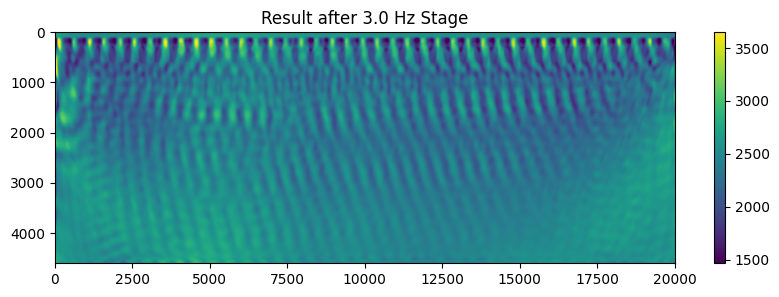


--- STAGE 2: Frequency 6.0 Hz ---
Epoch 20/100 | Loss: 34.380719
Epoch 40/100 | Loss: 31.954054
Epoch 60/100 | Loss: 30.623941
Epoch 80/100 | Loss: 29.835601
Epoch 100/100 | Loss: 29.271072


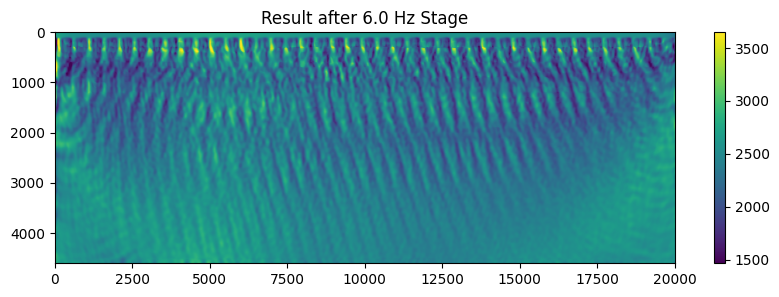


--- STAGE 3: Frequency 10.0 Hz ---


/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 10.0, a minimum non-zero velocity of 1465.0220947265625, and a grid cell spacing of 25.0, there are only 5.86.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/deepwave/common.py:1191: UserWarning: At least six grid cells per wavelength is recommended, but at a frequency of 10.0, a minimum non-zero velocity of 1450.0, and a grid cell spacing of 25.0, there are only 5.80.
  warnings.warn(


Epoch 20/100 | Loss: 19.317446
Epoch 40/100 | Loss: 19.160870
Epoch 60/100 | Loss: 19.066776
Epoch 80/100 | Loss: 18.988095
Epoch 100/100 | Loss: 18.923778


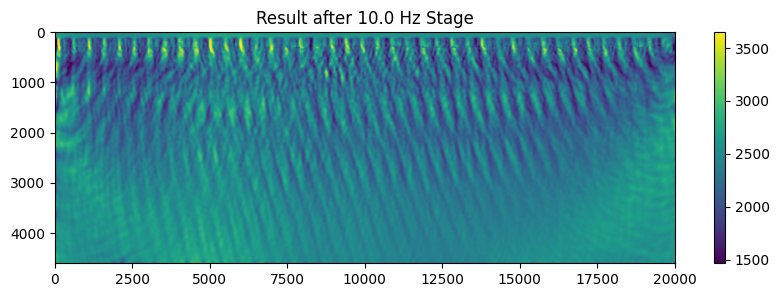

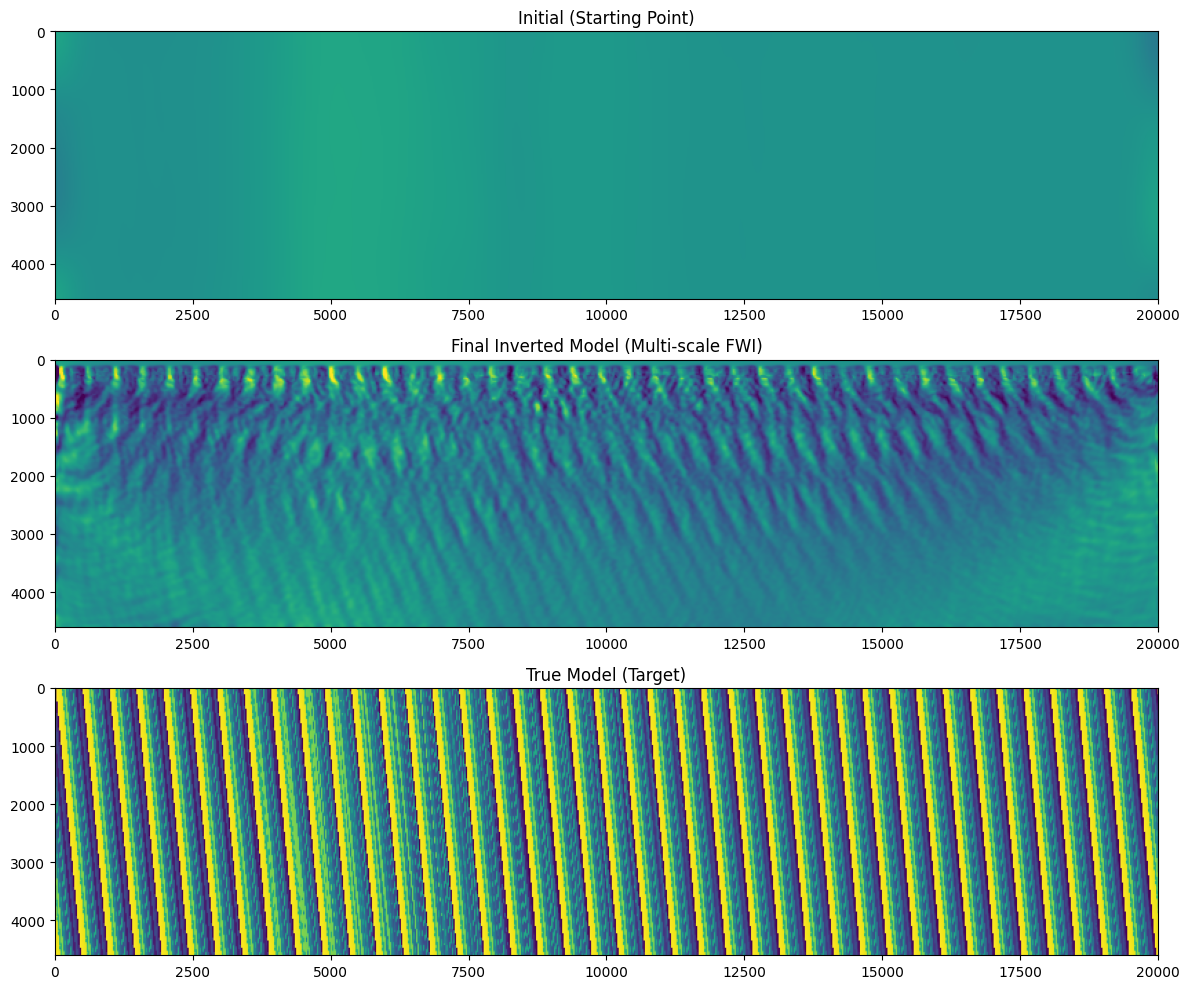

In [4]:
import numpy as np
import torch
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar

# 1. SETUP & DEVICE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Overthrust Dimensions
nx, nz = 801, 185
dx, dz = 25.0, 25.0
spacing = (dx, dz)
extent = [0, (nx-1)*dx, (nz-1)*dz, 0]

# 2. LOAD MODEL
vp_path = 'overthrust_vp.bin'
# Load as float32. Ensure the file is in your Colab folder.
v_true = torch.from_file(vp_path, size=nx * nz, dtype=torch.float32).reshape(nx, nz).to(device)

# 3. INITIAL MODEL & MASKING
# Start with a very smooth version to avoid cycle skipping
v_init_np = gaussian_filter(v_true.cpu().numpy(), sigma=12)
v1 = torch.tensor(v_init_np, device=device, requires_grad=True)

# Water layer mask (Top 200m / 25m = 8 cells)
water_depth_cells = 8
mask = torch.ones_like(v1)
mask[:, :water_depth_cells] = 0

# 4. ACQUISITION PARAMETERS
n_shots = 60
n_receivers_per_shot = 201
nt = 2400
dt = 0.004
# CRITICAL FIX: Batch size 2 ensures we don't exceed 15GB VRAM
batch_size = 2

source_loc = torch.zeros(n_shots, 1, 2, dtype=torch.long, device=device)
source_loc[:, 0, 0] = torch.linspace(0, nx - 1, n_shots).long()
source_loc[:, 0, 1] = 2

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = 2
for i in range(n_shots):
    receiver_loc[i, :, 0] = torch.linspace(0, nx - 1, n_receivers_per_shot).long()

# 5. MULTI-SCALE CONFIGURATION
# Start low (3Hz) to get the big shapes, end high (10Hz) for sharpness
frequencies = [3.0, 6.0, 10.0]
epochs_per_stage = [100, 100, 100] # Total 300 iterations
learning_rates = [25.0, 15.0, 10.0]

def taper(x):
    return deepwave.common.cosine_taper_end(x, n_taper=20)

# 6. INVERSION LOOP
losses = []
vmin, vmax = v_true.min().item(), v_true.max().item()

print("Starting Multi-scale Inversion (T4 Optimized)...")

for stage, (freq, n_epochs, lr) in enumerate(zip(frequencies, epochs_per_stage, learning_rates)):
    print(f"\n--- STAGE {stage+1}: Frequency {freq} Hz ---")

    peak_time = 1.5 / freq
    source_amp = deepwave.wavelets.ricker(freq, nt, dt, peak_time).repeat(n_shots, 1, 1).to(device)

    # Generate observed data (No gradients needed here)
    with torch.no_grad():
        observed_data = []
        for b in range(0, n_shots, batch_size):
            out = scalar(v_true, spacing, dt,
                         source_amplitudes=source_amp[b:b+batch_size],
                         source_locations=source_loc[b:b+batch_size],
                         receiver_locations=receiver_loc[b:b+batch_size],
                         pml_freq=freq)
            observed_data.append(taper(out[-1]))
        observed_data = torch.cat(observed_data)
        torch.cuda.empty_cache() # Clear wavefield memory

    optimizer = torch.optim.Adam([v1], lr=lr)

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        epoch_loss = 0

        # Inversion loop (Backward pass consumes most memory)
        for b in range(0, n_shots, batch_size):
            out_pred = scalar(v1, spacing, dt,
                             source_amplitudes=source_amp[b:b+batch_size],
                             source_locations=source_loc[b:b+batch_size],
                             receiver_locations=receiver_loc[b:b+batch_size],
                             pml_freq=freq)

            loss = torch.nn.MSELoss()(taper(out_pred[-1]), observed_data[b:b+batch_size])
            # Scale loss by batch to keep gradients consistent
            (loss / (n_shots // batch_size)).backward()
            epoch_loss += loss.item()

        # Gradient Conditioning
        with torch.no_grad():
            v1.grad *= mask
            # Smooth gradient to remove jitter/artifacts
            grad_smoothed = gaussian_filter(v1.grad.cpu().numpy(), sigma=1.5)
            v1.grad.copy_(torch.tensor(grad_smoothed).to(device))
            # Clip outlier values
            torch.nn.utils.clip_grad_value_([v1], torch.quantile(v1.grad.abs(), 0.95))

        optimizer.step()

        # Constraints
        with torch.no_grad():
            v1.clamp_(min=1450.0, max=5500.0)

        losses.append(epoch_loss)

        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{n_epochs} | Loss: {epoch_loss:.6f}")
            torch.cuda.empty_cache() # Regularly clear fragmentation

    # Visualize Progress
    plt.figure(figsize=(10, 3))
    plt.imshow(v1.detach().cpu().T, cmap='viridis', aspect='auto', extent=extent, vmin=vmin, vmax=vmax)
    plt.title(f"Result after {freq} Hz Stage")
    plt.colorbar()
    plt.show()

# 7. FINAL COMPARISON
fig, ax = plt.subplots(3, 1, figsize=(12, 10))
ax[0].imshow(v_init_np.T, cmap='viridis', aspect='auto', extent=extent, vmin=vmin, vmax=vmax)
ax[0].set_title("Initial (Starting Point)")
ax[1].imshow(v1.detach().cpu().T, cmap='viridis', aspect='auto', extent=extent, vmin=vmin, vmax=vmax)
ax[1].set_title("Final Inverted Model (Multi-scale FWI)")
ax[2].imshow(v_true.cpu().T, cmap='viridis', aspect='auto', extent=extent, vmin=vmin, vmax=vmax)
ax[2].set_title("True Model (Target)")
plt.tight_layout()
plt.show()